In [7]:
from neural_priors.utils.data import Subject, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from neural_priors.utils.data import Subject
from tqdm.contrib.itertools import product


In [8]:
behavior = get_all_behavioral_data()

In [9]:
bids_folder = '/data/ds-neuralpriors'

load_data_via_tsv = True

In [10]:


if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5],
                    dtype={'subject':str})

    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 25)]
    subjects.pop(subjects.index('11'))
    subjects.pop(subjects.index('16'))
    subjects.pop(subjects.index('23'))

    for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        df.append(sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n))
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack('range_n')

In [11]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('width', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
df.stack('range_n').groupby(['smoothed', 'range_n', 'model']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('model')

model               gaussian  lognormal
smoothed   range_n                     
smoothed   both     0.178352   0.185989
           narrow   0.187088   0.191195
           wide     0.156485   0.161055
           wide2    0.045412   0.048652
unsmoothed both     0.094065   0.097883
           narrow   0.109742   0.111940
           wide     0.098403   0.101354
           wide2    0.032165   0.033206

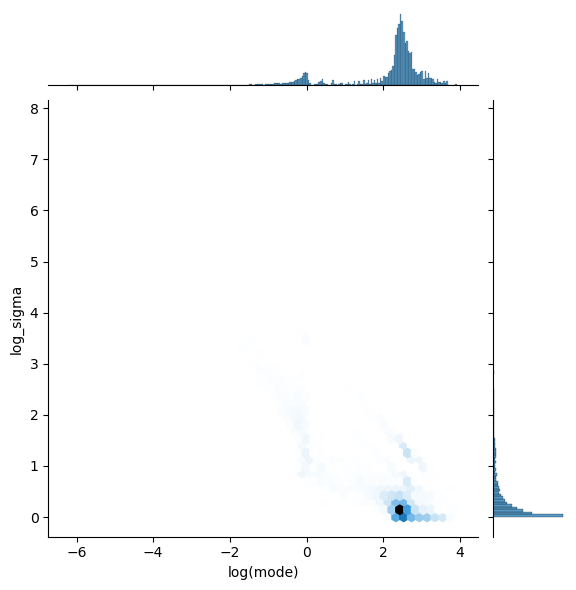

In [13]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')

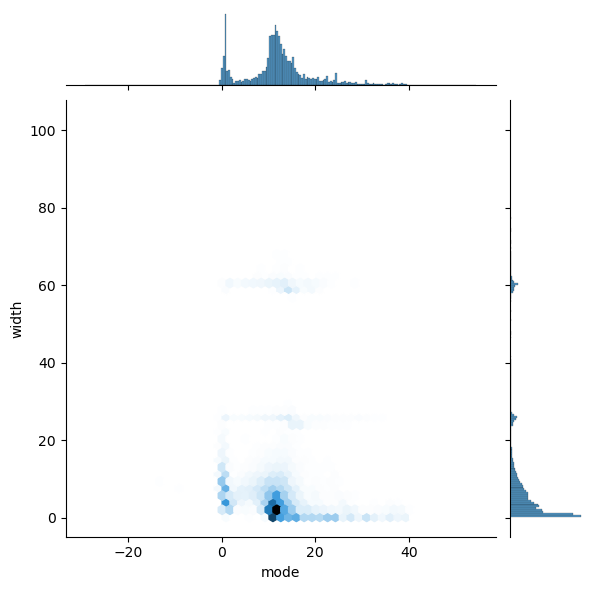

In [64]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.00]
sns.jointplot(x='mode', y='width', data=tmp.reset_index(), kind='hex')

In [69]:
df['cvr2'].unstack('model').xs('gaussian', 1, 'model') > df['cvr2'].unstack('model').xs('lognormal', 1, 'model').groupby(['subject', ''])

range_n                            both  narrow   wide  wide2
subject session smoothed   voxel                             
01      both    smoothed   0      False    True  False  False
                           1      False    True   True  False
                           2      False   False  False   True
                           3      False   False  False  False
                           4       True    True  False   True
...                                 ...     ...    ...    ...
24      both    unsmoothed 492    False   False   True   True
                           493     True    True   True  False
                           494     True   False   True  False
                           495    False    True  False  False
                           496     True    True   True  False

[34572 rows x 4 columns]

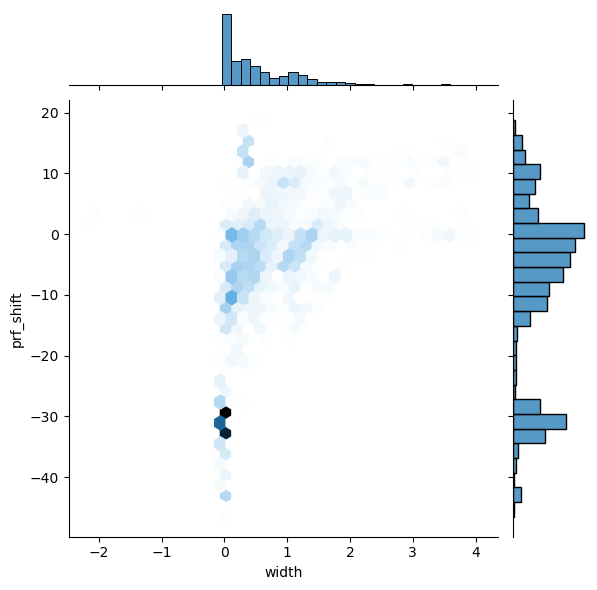

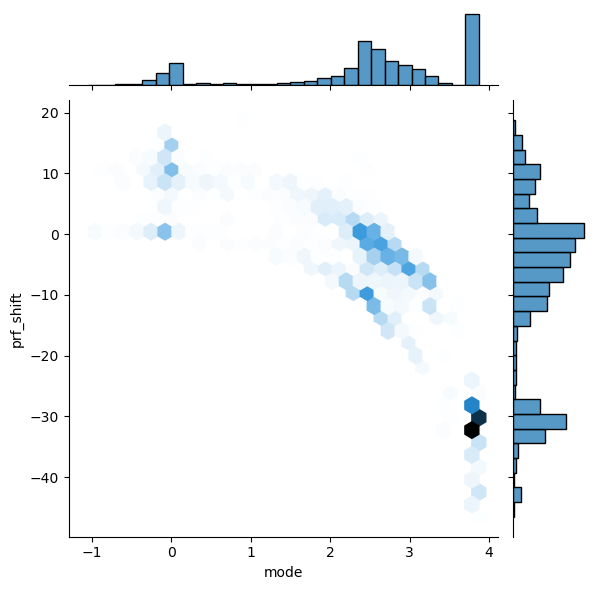

In [52]:
mask = (df[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.01) & (df[('mode', 'narrow')] < 25)
prf_shift = df.loc[mask, ('mode', 'narrow')] - df.loc[mask, ('mode', 'wide')]

tmp = prf_shift.to_frame('prf_shift').join(df[('log_sigma', 'wide')].to_frame('width'))
tmp = tmp.join(df[('log(mode)', 'wide')].to_frame('mode'))

sns.jointplot(y='prf_shift', x='width', data=tmp.reset_index(), kind='hex')
sns.jointplot(y='prf_shift', x='mode', data=tmp.reset_index(), kind='hex')

n         r           CI95%     p-val   BF10     power
range                                                                  
narrow pearson  22 -0.294757   [-0.64, 0.14]  0.182977  0.609  0.271003
wide   pearson  22 -0.457123  [-0.74, -0.04]  0.032446  2.268  0.592317

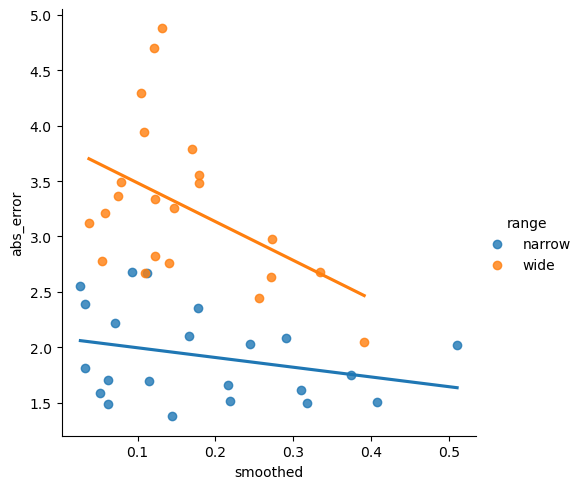

In [14]:
import pingouin as pg
r2 = df.xs('lognormal', 0, level='model').stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject', 'range'])[['abs_error']].mean().join(r2)

sns.lmplot(x='smoothed', y='abs_error', hue='range', data=tmp.reset_index(), ci=None)

tmp.groupby(['range']).apply(lambda d: pg.corr(d['abs_error'], d['smoothed'], method='pearson'))

n         r          CI95%     p-val   BF10     power
pearson  22 -0.415627  [-0.71, 0.01]  0.054388  1.505  0.502301

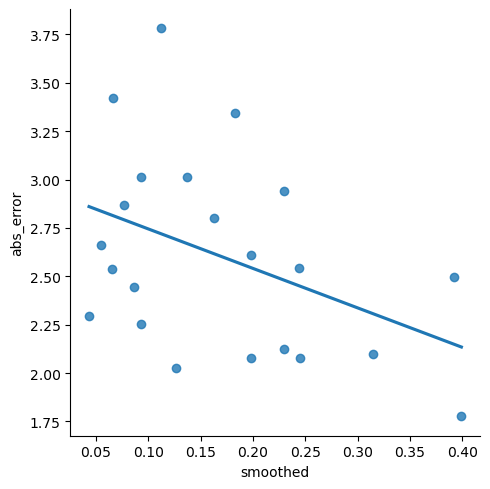

In [15]:
import pingouin as pg
r2 = df.xs('lognormal', 0, 'model').stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject'])[['abs_error']].mean().join(r2.loc[(slice(None), 'both', ['narrow', 'wide'])].groupby('subject').mean())

sns.lmplot(x='smoothed', y='abs_error', data=tmp.reset_index(), ci=None)

pg.corr(tmp['abs_error'], tmp['smoothed'], method='pearson')

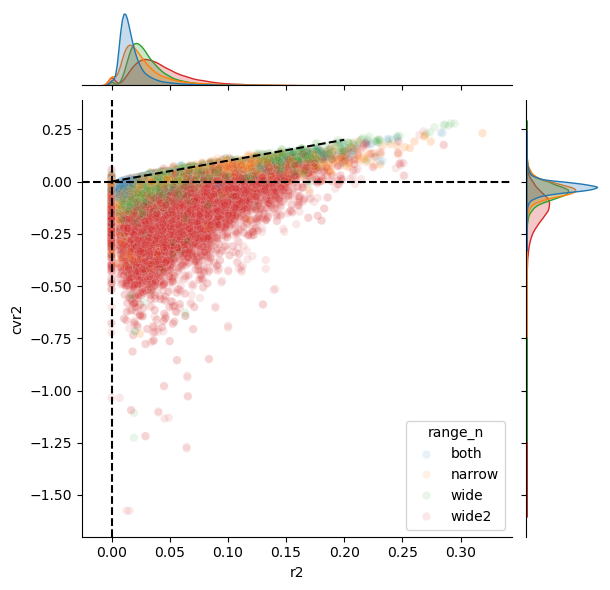

In [16]:
tmp = df.stack(1)


sns.jointplot(data=tmp, x='r2', y='cvr2', hue='range_n', alpha=0.1)
plt.axhline(0.0, c='k', ls='--')
plt.axvline(0.0, c='k', ls='--')
plt.plot([0, .2], [0, .2], c='k', ls='--')

In [17]:
df.groupby(['subject', 'session', 'smoothed']).apply(lambda d: (d[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.00).any(axis=1).mean()).unstack('smoothed')

smoothed         smoothed  unsmoothed
subject session                      
01      both     0.108949    0.105707
02      both     0.162791    0.137209
03      both     0.125350    0.111345
04      both     0.273548    0.189032
05      both     0.093796    0.160266
06      both     0.247826    0.156522
07      both     0.468610    0.213565
08      both     0.308176    0.160377
09      both     0.384615    0.200157
10      both     0.162853    0.148721
12      both     0.534831    0.352247
13      both     0.527582    0.300469
14      both     0.171250    0.144375
15      both     0.369251    0.191853
16      both     0.383772    0.279971
17      both     0.242308    0.197436
18      both     0.148123    0.117292
19      both     0.349438    0.232022
20      both     0.323588    0.199207
21      both     0.080827    0.102130
22      both     0.389149    0.232928
24      both     0.219316    0.115694

In [18]:
df.groupby(['subject', 'session', 'smoothed']).apply(lambda d: (d[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.00).all(axis=1).mean()).unstack('smoothed')

smoothed         smoothed  unsmoothed
subject session                      
01      both     0.001297    0.003891
02      both     0.020349    0.010465
03      both     0.004202    0.002801
04      both     0.053548    0.028387
05      both     0.006647    0.006647
06      both     0.015528    0.008696
07      both     0.153027    0.034753
08      both     0.048742    0.011792
09      both     0.081633    0.024333
10      both     0.014805    0.004038
12      both     0.234831    0.087079
13      both     0.252934    0.086854
14      both     0.016875    0.005000
15      both     0.021682    0.015112
16      both     0.070175    0.024854
17      both     0.028205    0.014744
18      both     0.005362    0.004692
19      both     0.138202    0.054494
20      both     0.067889    0.015362
21      both     0.004386    0.003133
22      both     0.069691    0.019645
24      both     0.009054    0.003018

# Narrow vs wide

In [34]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed', 'model']).sort_index()
tmp = tmp[(tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.01).any(axis=1)]
tmp = tmp[(tmp[[('r2', 'wide'), ('r2', 'narrow')]] > 0.01).all(axis=1)]
# tmp = tmp[(tmp[[('amplitude', 'wide'), ('amplitude', 'narrow')]] > 0.01).all(axis=1)]

# tmp = tmp[(tmp[('mode', 'wide')] > 10.) & (tmp[('mode', 'narrow')] > 10.)]

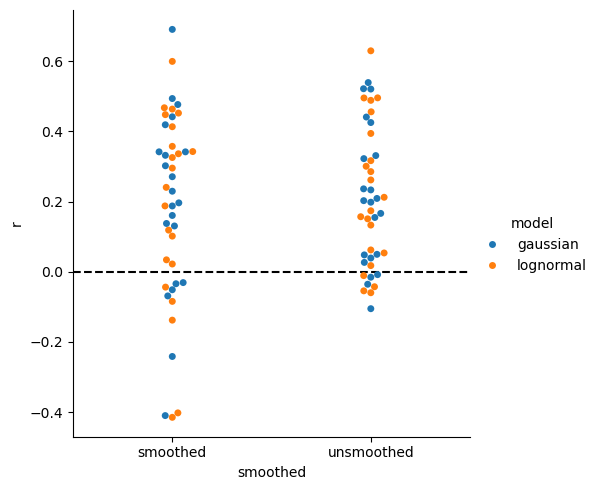

In [36]:
import pingouin as pg
r = tmp.groupby(['subject', 'smoothed', 'model']).apply(lambda d: pg.corr(d[('mode', 'narrow')], d[('mode', 'wide')]) if len(d) > 1 else pd.Series([0.0], index=['r']))


sns.catplot(x='smoothed', y='r', data=r.reset_index(), hue='model', kind='swarm')
plt.axhline(0.0, c='k', ls='--')

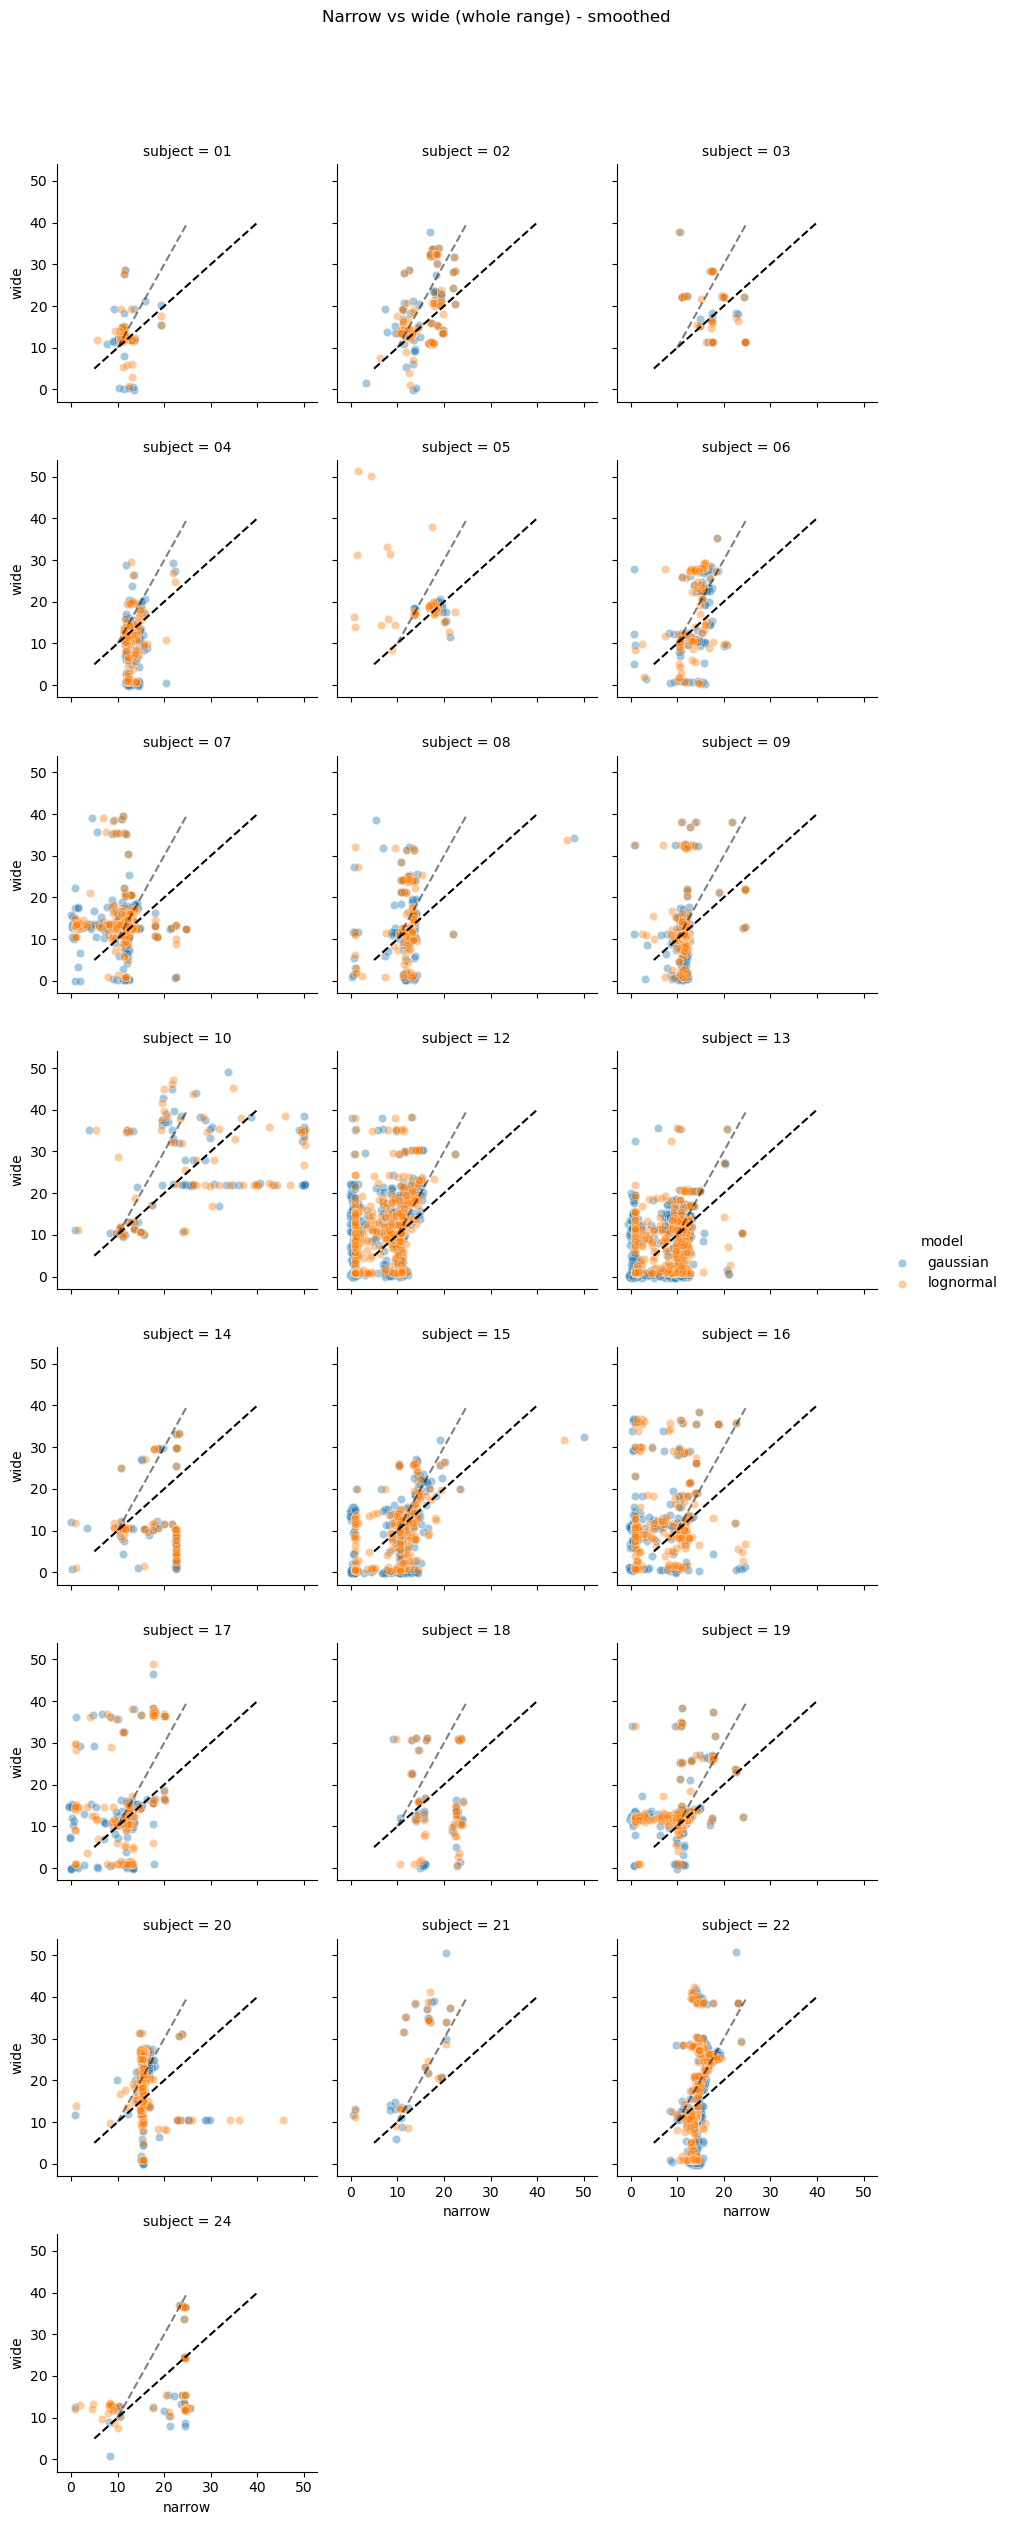

<Figure size 640x480 with 0 Axes>

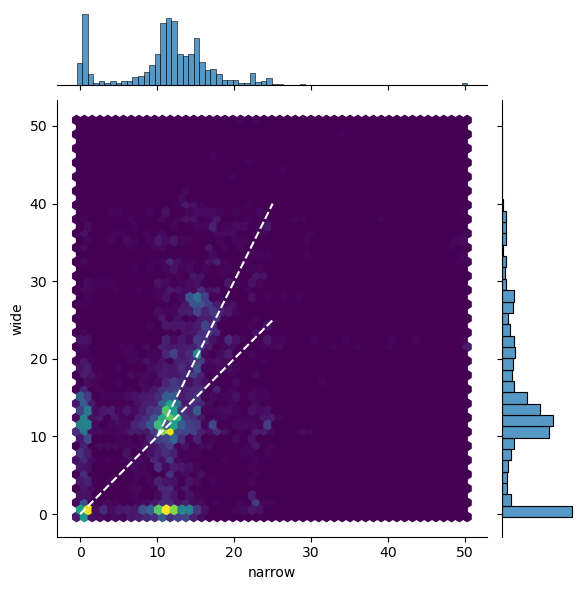

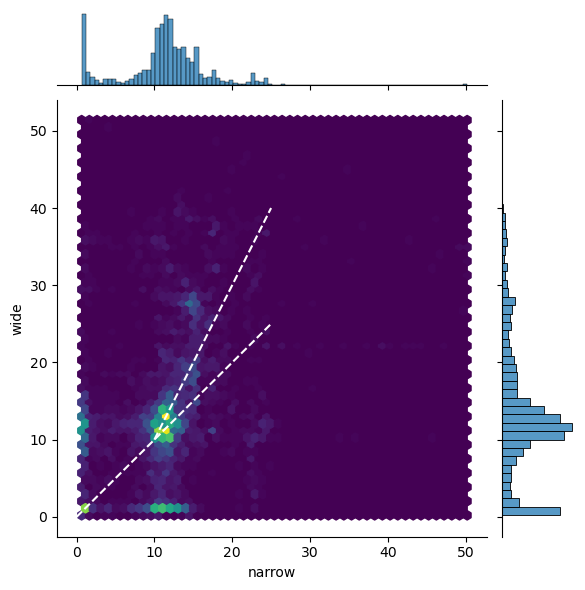

In [32]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3, hue='model')

g.map(sns.scatterplot, 'narrow', 'wide', alpha=0.4)
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')
    ax.plot([10, 25], [10, 40], color='black', linestyle='--', alpha=0.5)

g.add_legend()
g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed').xs('gaussian', 0, 'model')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([0, 25], [0, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed').xs('lognormal', 0, 'model')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([0, 25], [0, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

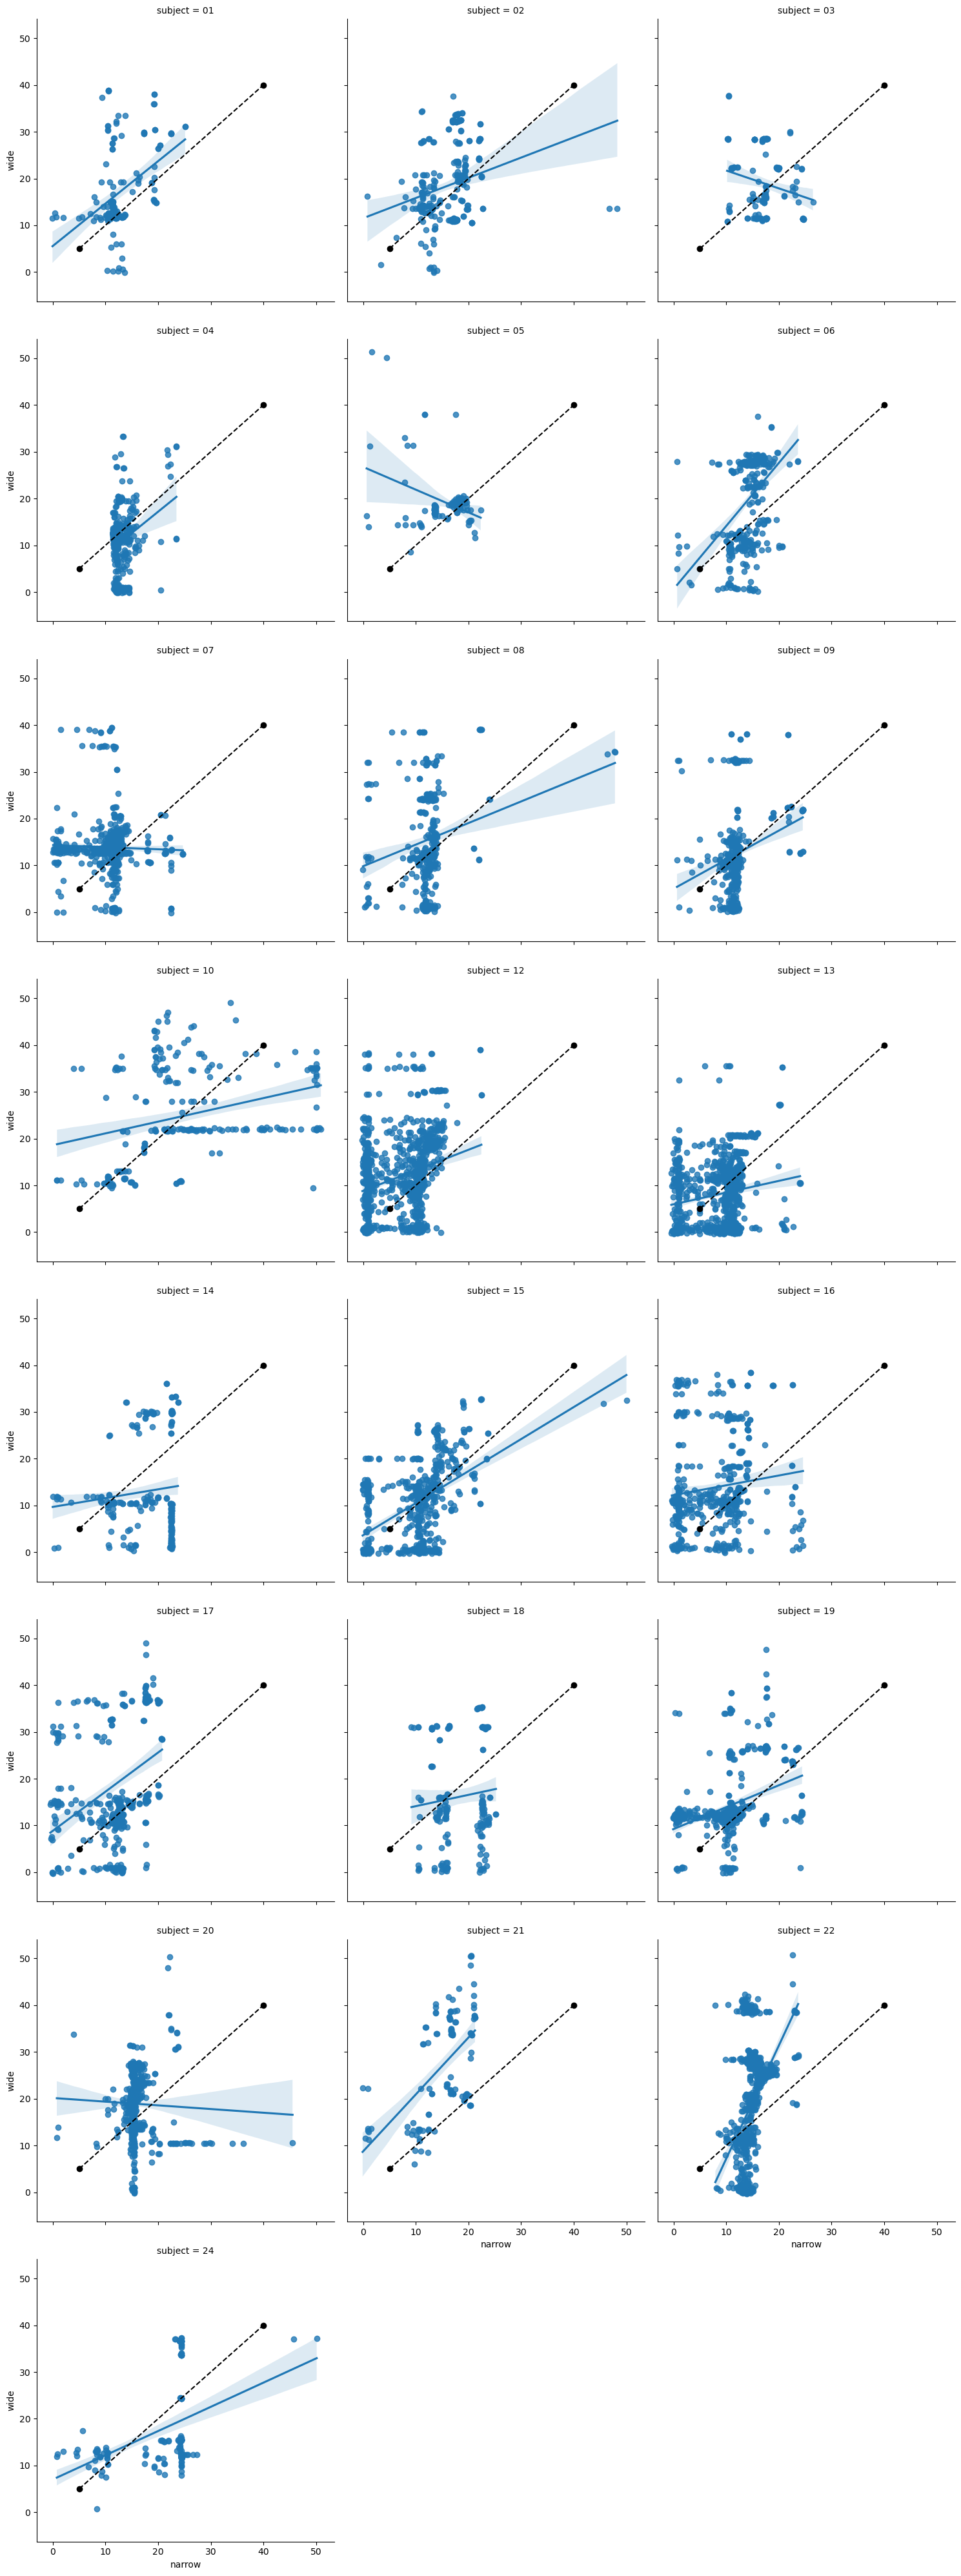

In [22]:
g = sns.lmplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', col='subject', col_wrap=3)

g.map(lambda x, y, **kwargs: plt.plot(x, y, **kwargs), x=[5, 40], y=[5, 40], color='black', linestyle='--')

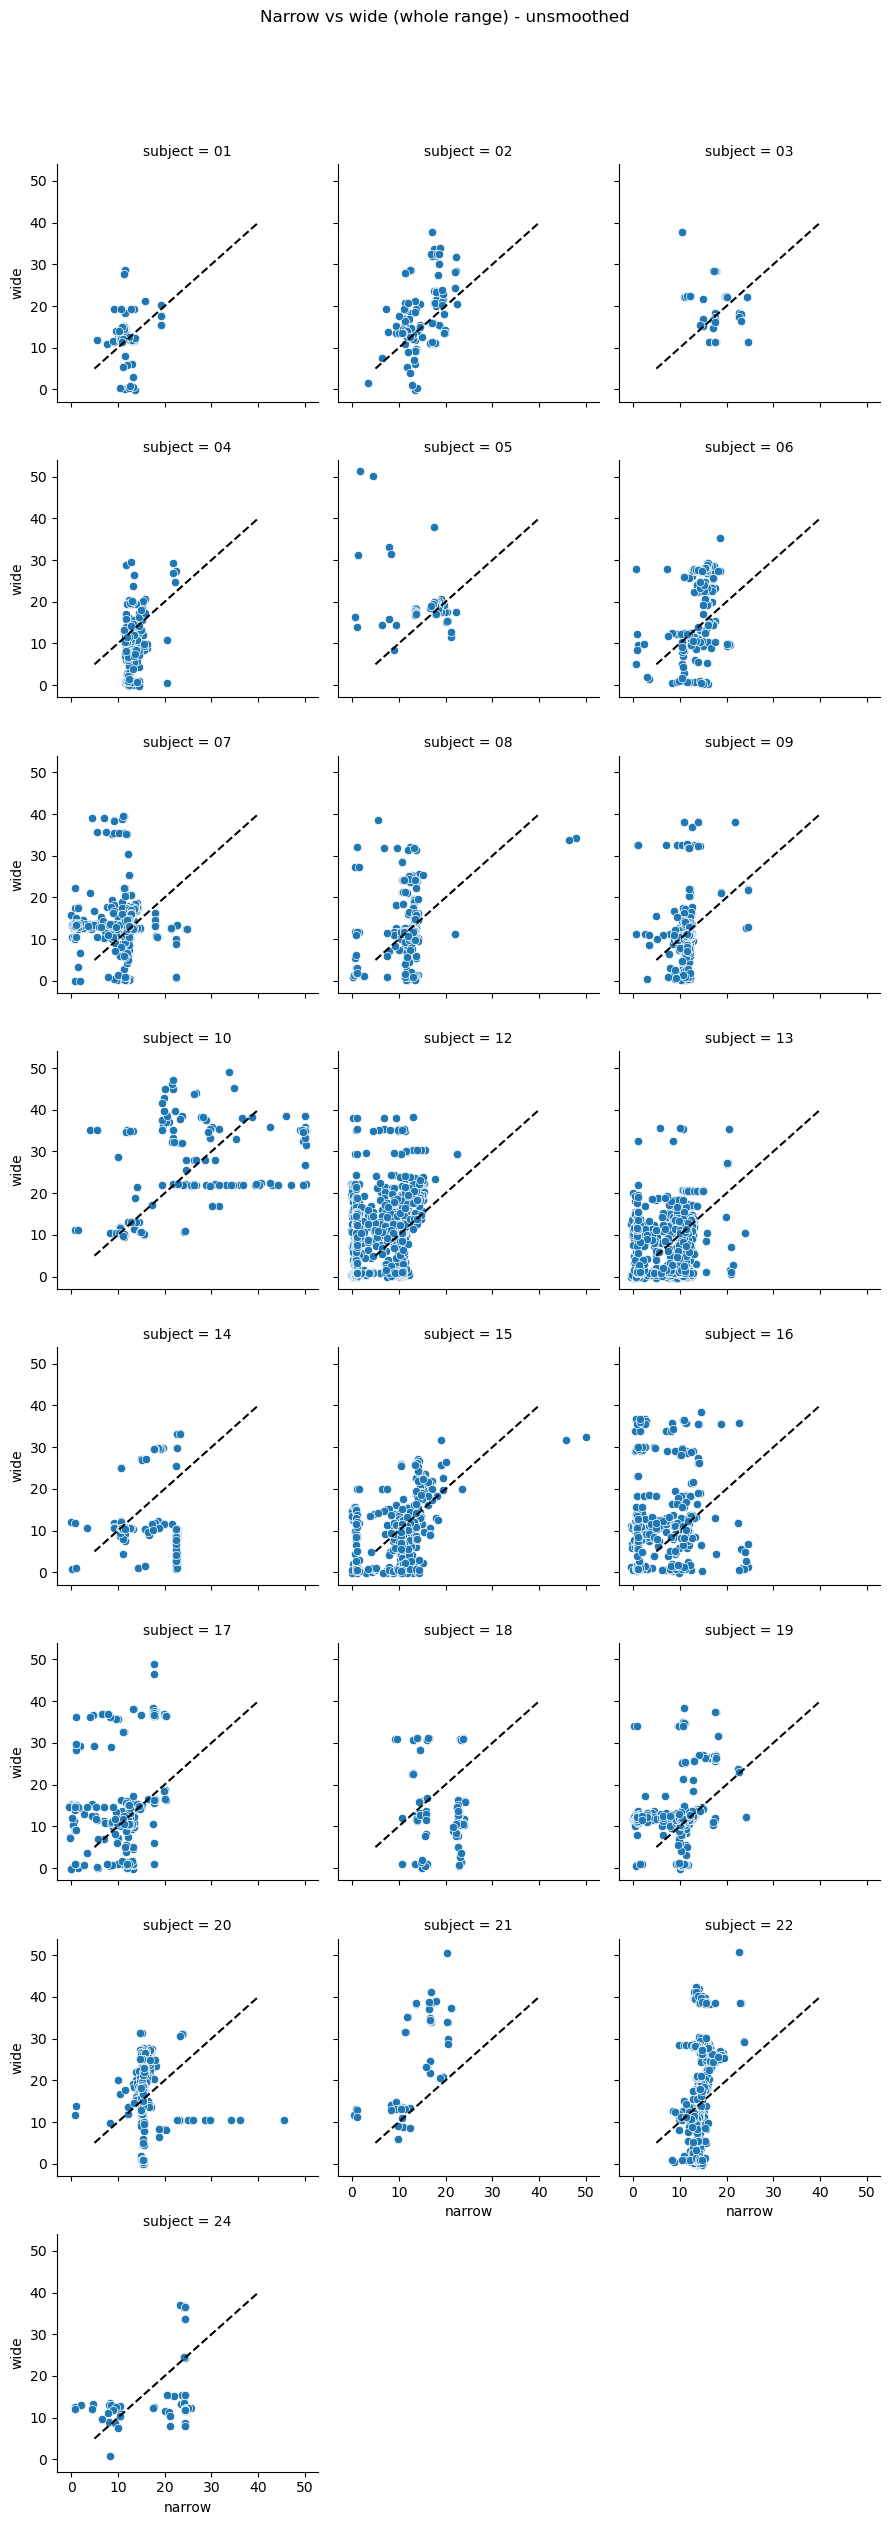

<Figure size 640x480 with 0 Axes>

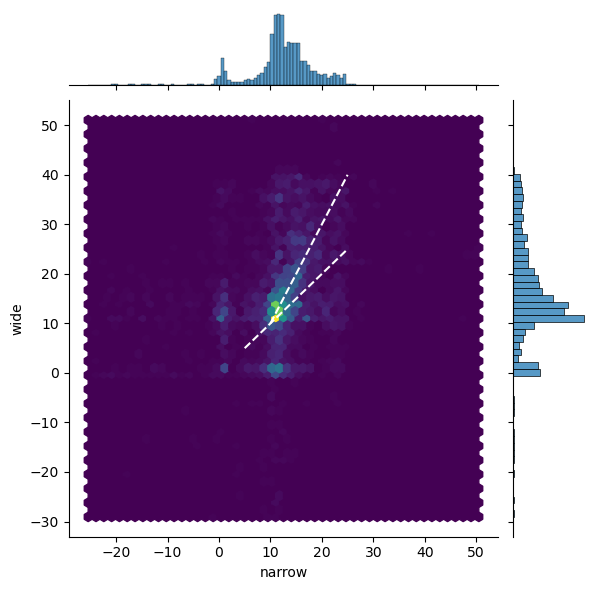

In [33]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - unsmoothed', y=1.05)

plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([5, 25], [5, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

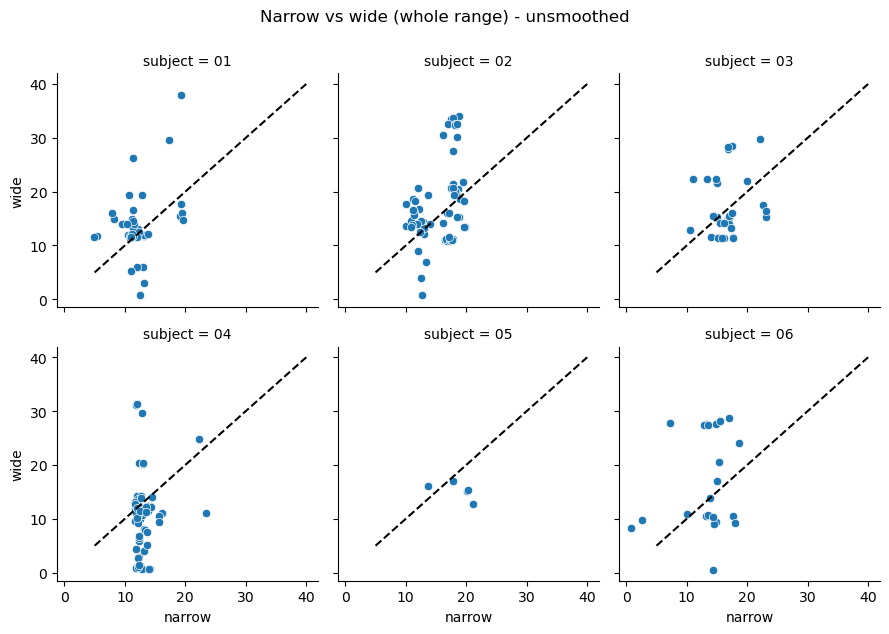

<Figure size 640x480 with 0 Axes>

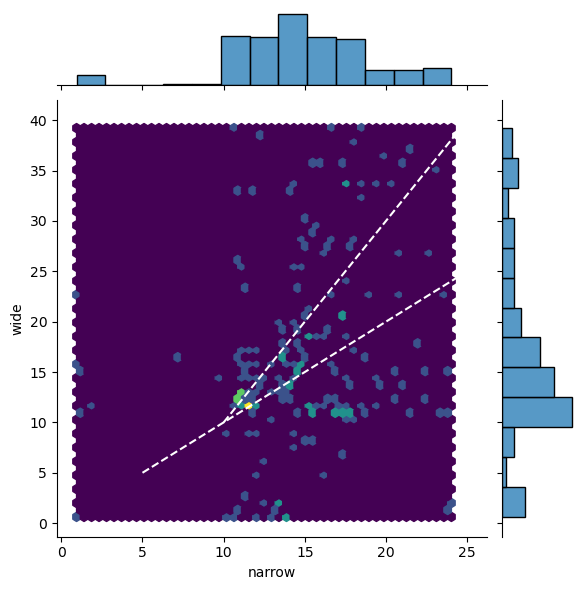

In [124]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - unsmoothed', y=1.05)

plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([5, 25], [5, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

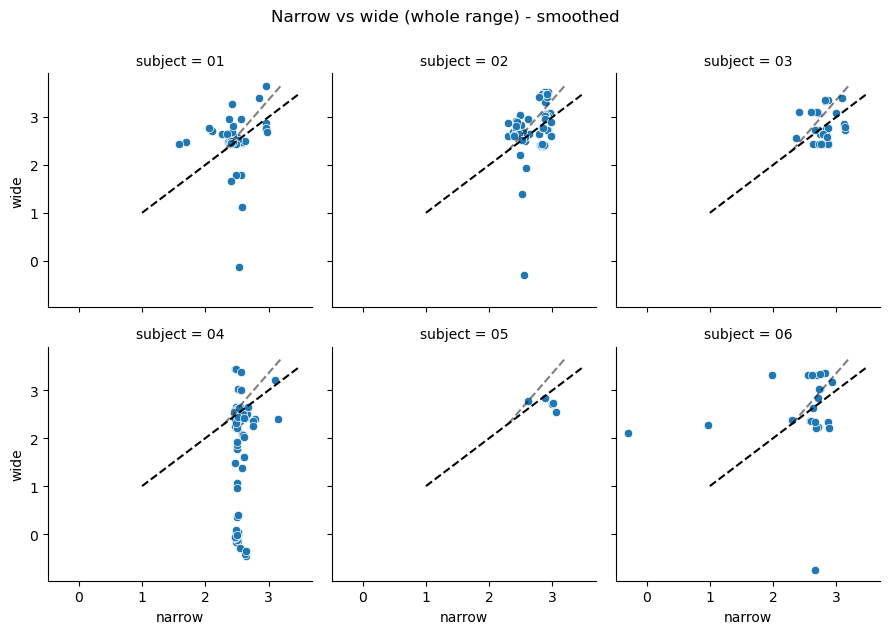

<Figure size 640x480 with 0 Axes>

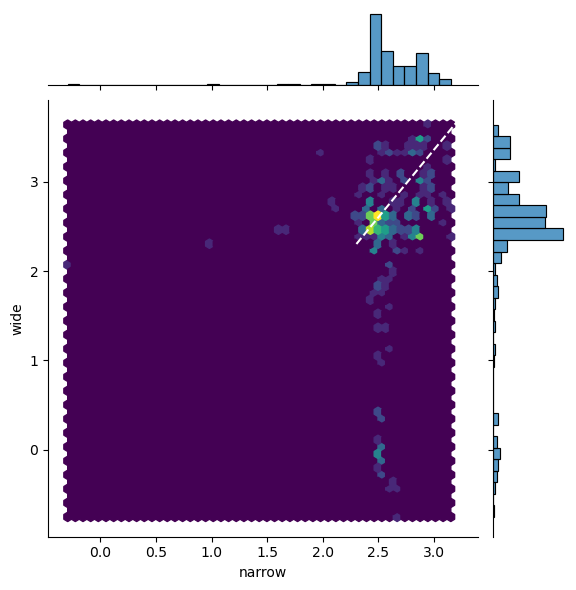

In [125]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')

for ax in g.axes.flat:
    ax.plot([1, 3.5], [1, 3.5], color='black', linestyle='--')
    ax.plot([np.log(10), np.log(25)], [np.log(10), np.log(40)], color='black', linestyle='--', alpha=0.5)

g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)

plt.plot([np.log(10),np.log(25)], [np.log(10), np.log(40)], color='white', linestyle='--')

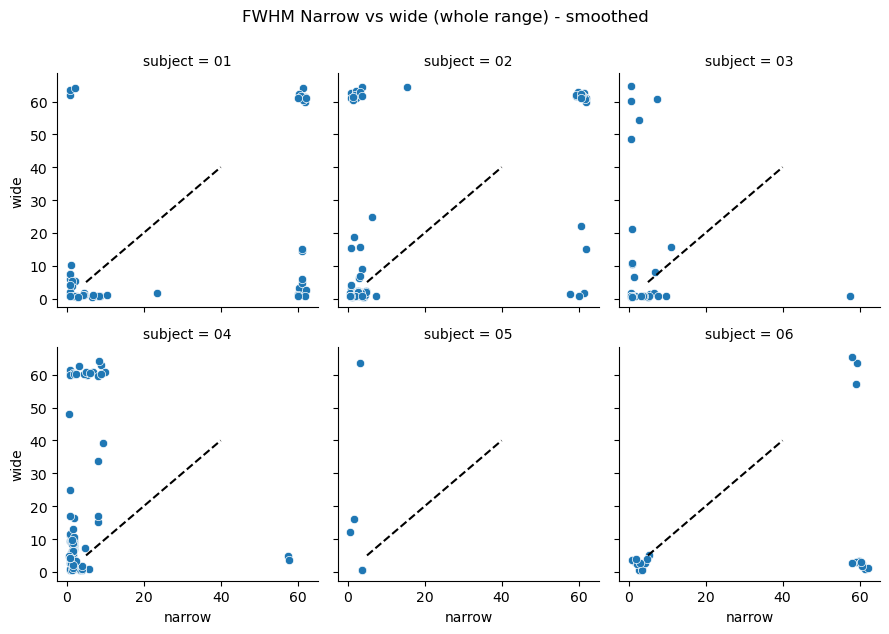

<Figure size 640x480 with 0 Axes>

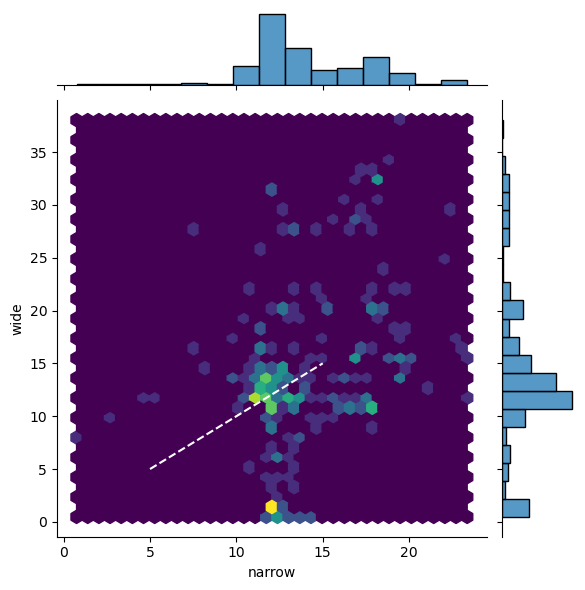

In [126]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['fwhm'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('FWHM Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([5, 15], [5, 15], color='white', linestyle='--')

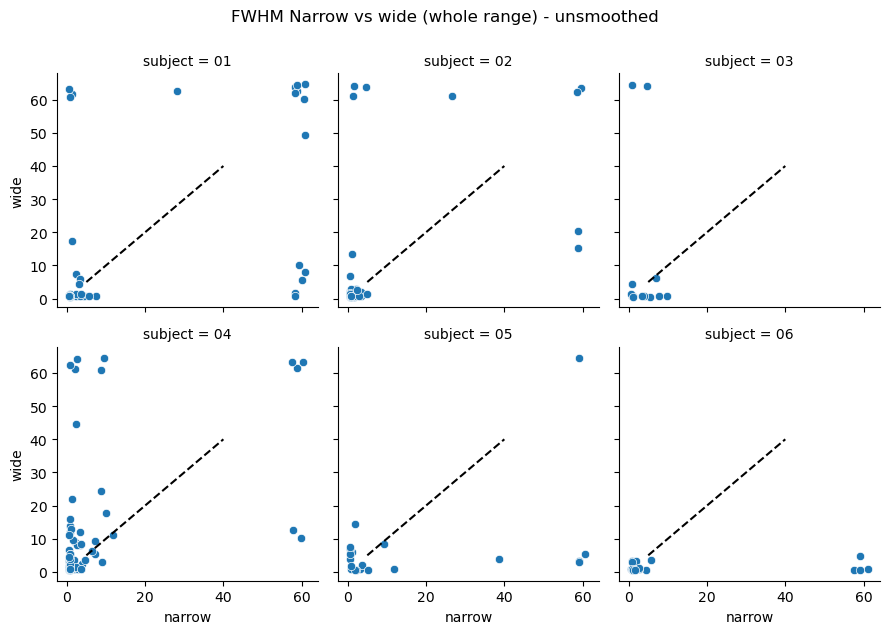

<Figure size 640x480 with 0 Axes>

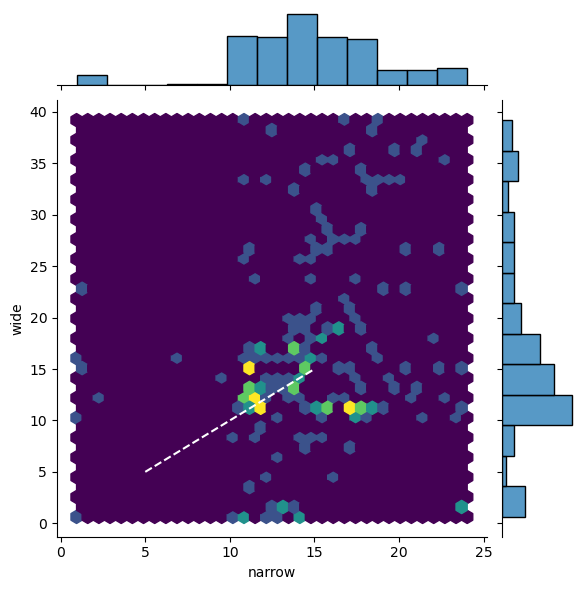

In [127]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['fwhm'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('FWHM Narrow vs wide (whole range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([5, 15], [5, 15], color='white', linestyle='--')

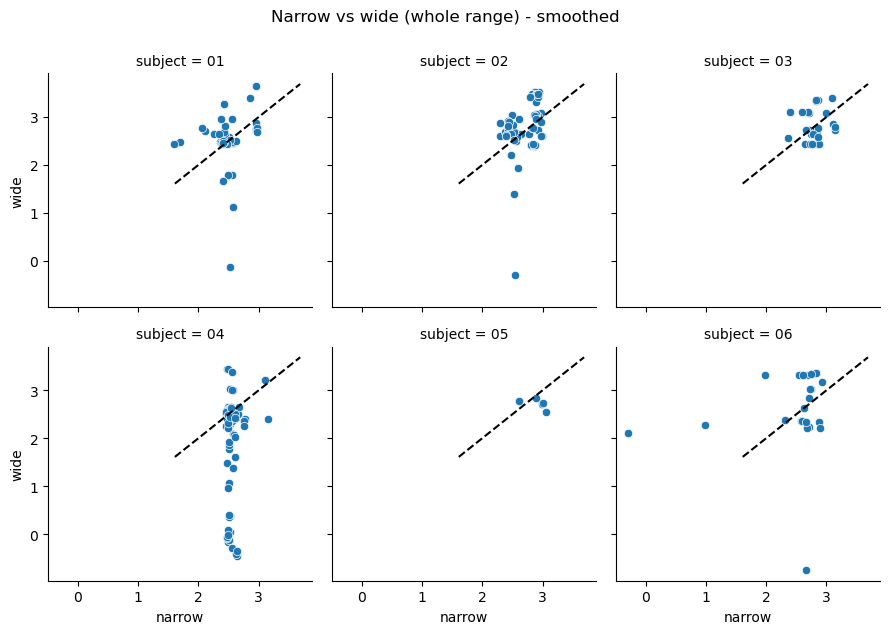

<Figure size 640x480 with 0 Axes>

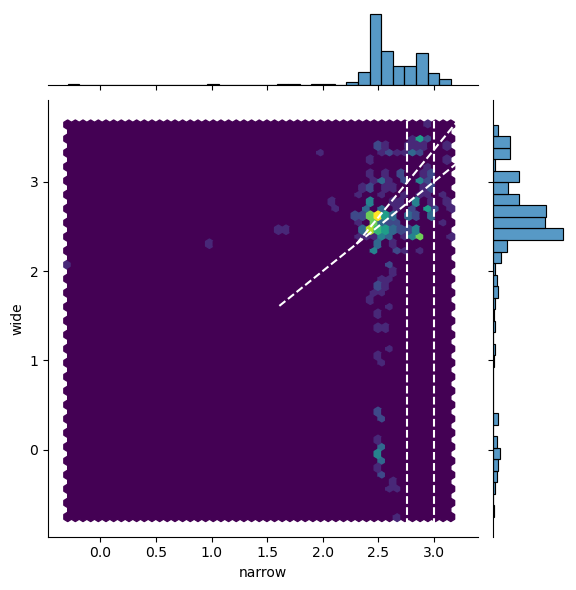

In [131]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([np.log(5), np.log(40)], [np.log(5), np.log(40)], color='black', linestyle='--')
#     ax.plot([10, 25], [10, 40], color='black', linestyle='--', alpha=0.5)


g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([np.log(5), np.log(25)], [np.log(5), np.log(25)], color='white', linestyle='--')
plt.plot([np.log(10), np.log(25)], [np.log(10), np.log(40)], color='white', linestyle='--')

plt.axvline((np.log(25) + np.log(10))/2., c='w', ls='--')
plt.axvline((np.log(40) + np.log(10))/2., c='w', ls='--')

In [129]:
# tmp = df['mode']

import bambi as bmb

# bmb.model()

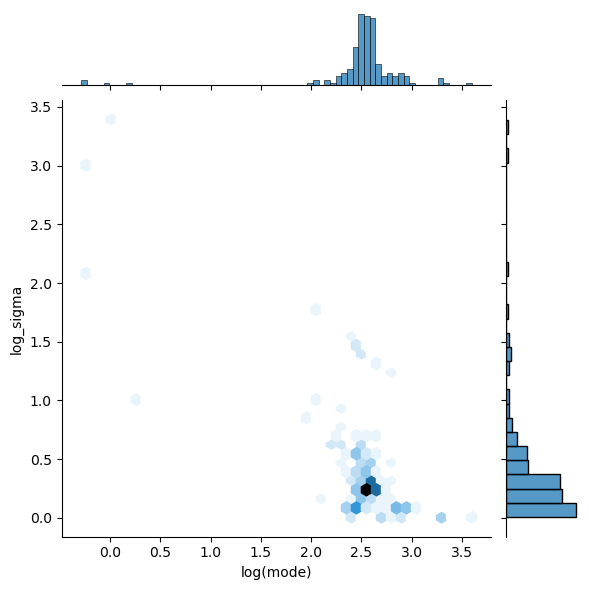

In [130]:
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp[tmp[('cvr2', 'both')] > 0.0].xs('both', axis=1, level='range_n'), kind='hex')

In [39]:
plt.hexbin?

Signature:
plt.hexbin(
    x,
    y,
    C=None,
    gridsize=100,
    bins=None,
    xscale='linear',
    yscale='linear',
    extent=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    edgecolors='face',
    reduce_C_function=<function mean at 0x104ef28b0>,
    mincnt=None,
    marginals=False,
    *,
    data=None,
    **kwargs,
)
Docstring:
Make a 2D hexagonal binning plot of points *x*, *y*.

If *C* is *None*, the value of the hexagon is determined by the number
of points in the hexagon. Otherwise, *C* specifies values at the
coordinate (x[i], y[i]). For each hexagon, these values are reduced
using *reduce_C_function*.

Parameters
----------
x, y : array-like
    The data positions. *x* and *y* must be of the same length.

C : array-like, optional
    If given, these values are accumulated in the bins. Otherwise,
    every point has a value of 1. Must be of the same length as *x*
    and *y*.

gridsize : int or (int, int), def

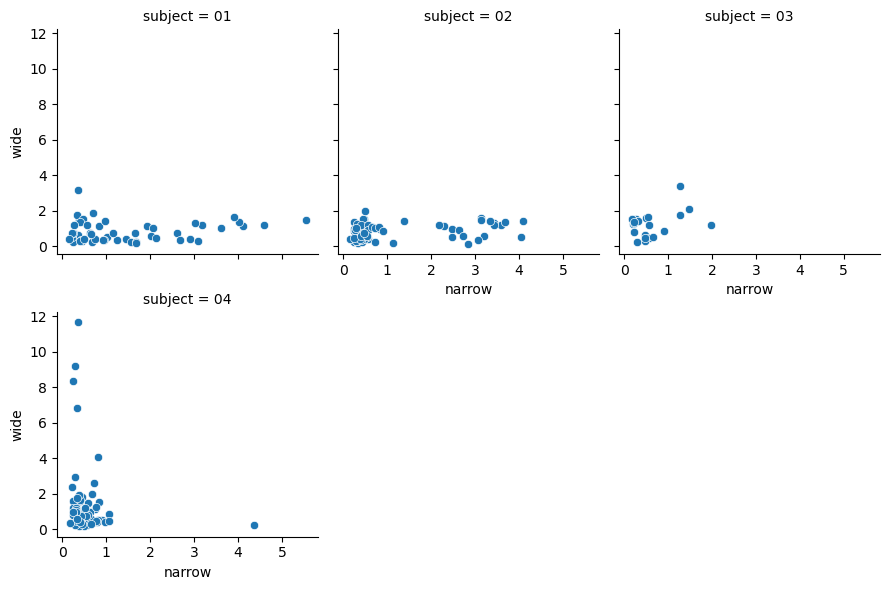

<Figure size 640x480 with 0 Axes>

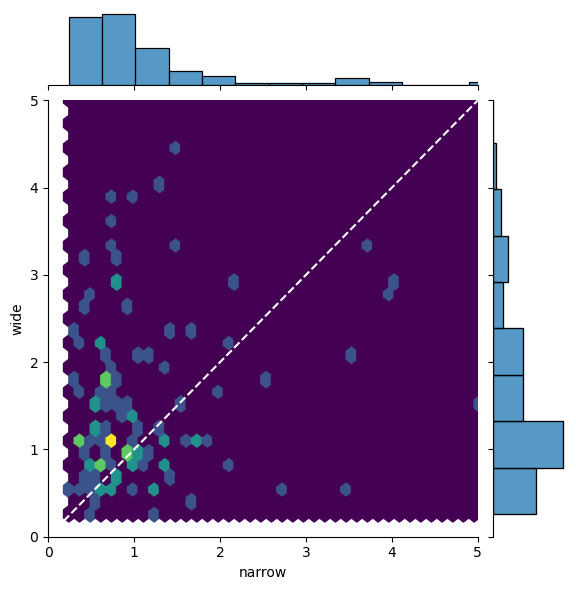

In [23]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['amplitude'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
plt.figure()

g = sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['amplitude'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=100)

g.ax_joint.set_xlim(0, 5)
g.ax_joint.set_ylim(0, 5)

g.ax_joint.plot([0, 5], [0, 5], color='white', linestyle='--')

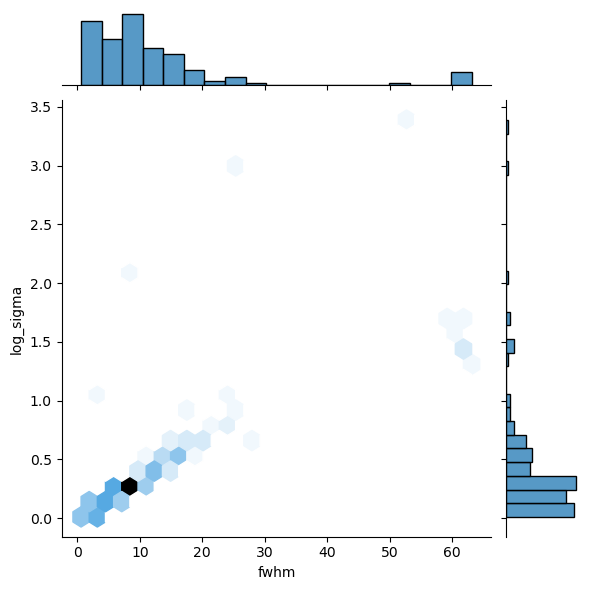

In [24]:
sns.jointplot(x='fwhm', y='log_sigma', data=tmp[tmp[('cvr2', 'both')] > 0.0].xs('both', axis=1, level='range_n'), kind='hex')

In [ ]:
mptmp

# Narrow vs wide 2

In [132]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed']).sort_index()
# tmp = tmp[(tmp[('cvr2', 'both')] > 0.00)]
# tmp = tmp[tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.00]
tmp = tmp[(tmp[[('cvr2', 'wide2'), ('cvr2', 'narrow')]] > 0.00).any(axis=1)]

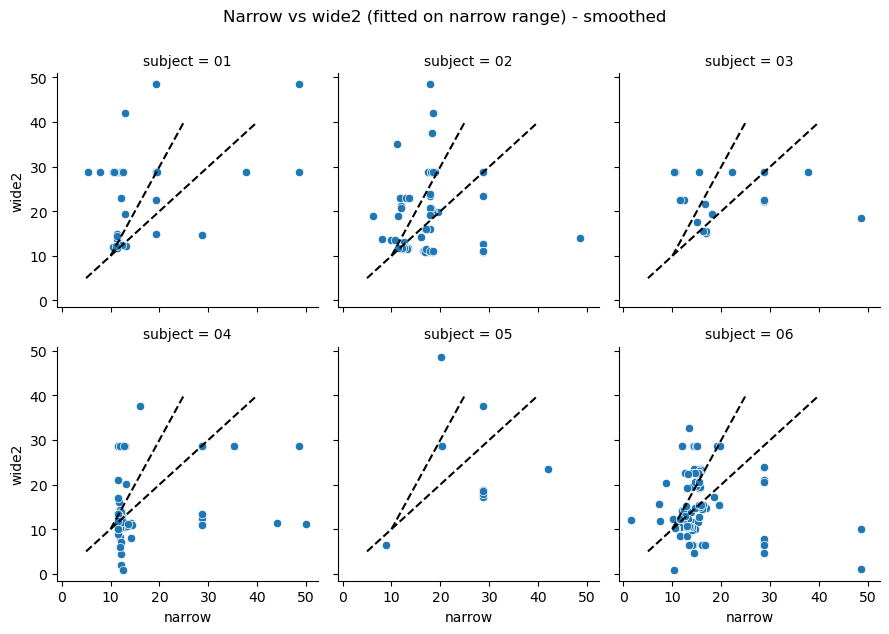

<Figure size 640x480 with 0 Axes>

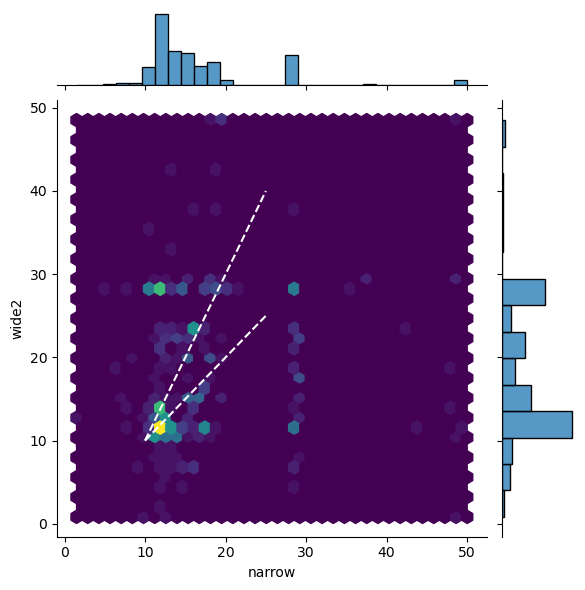

In [133]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide2')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')
    ax.plot([10, 25], [10, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide2 (fitted on narrow range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide2', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

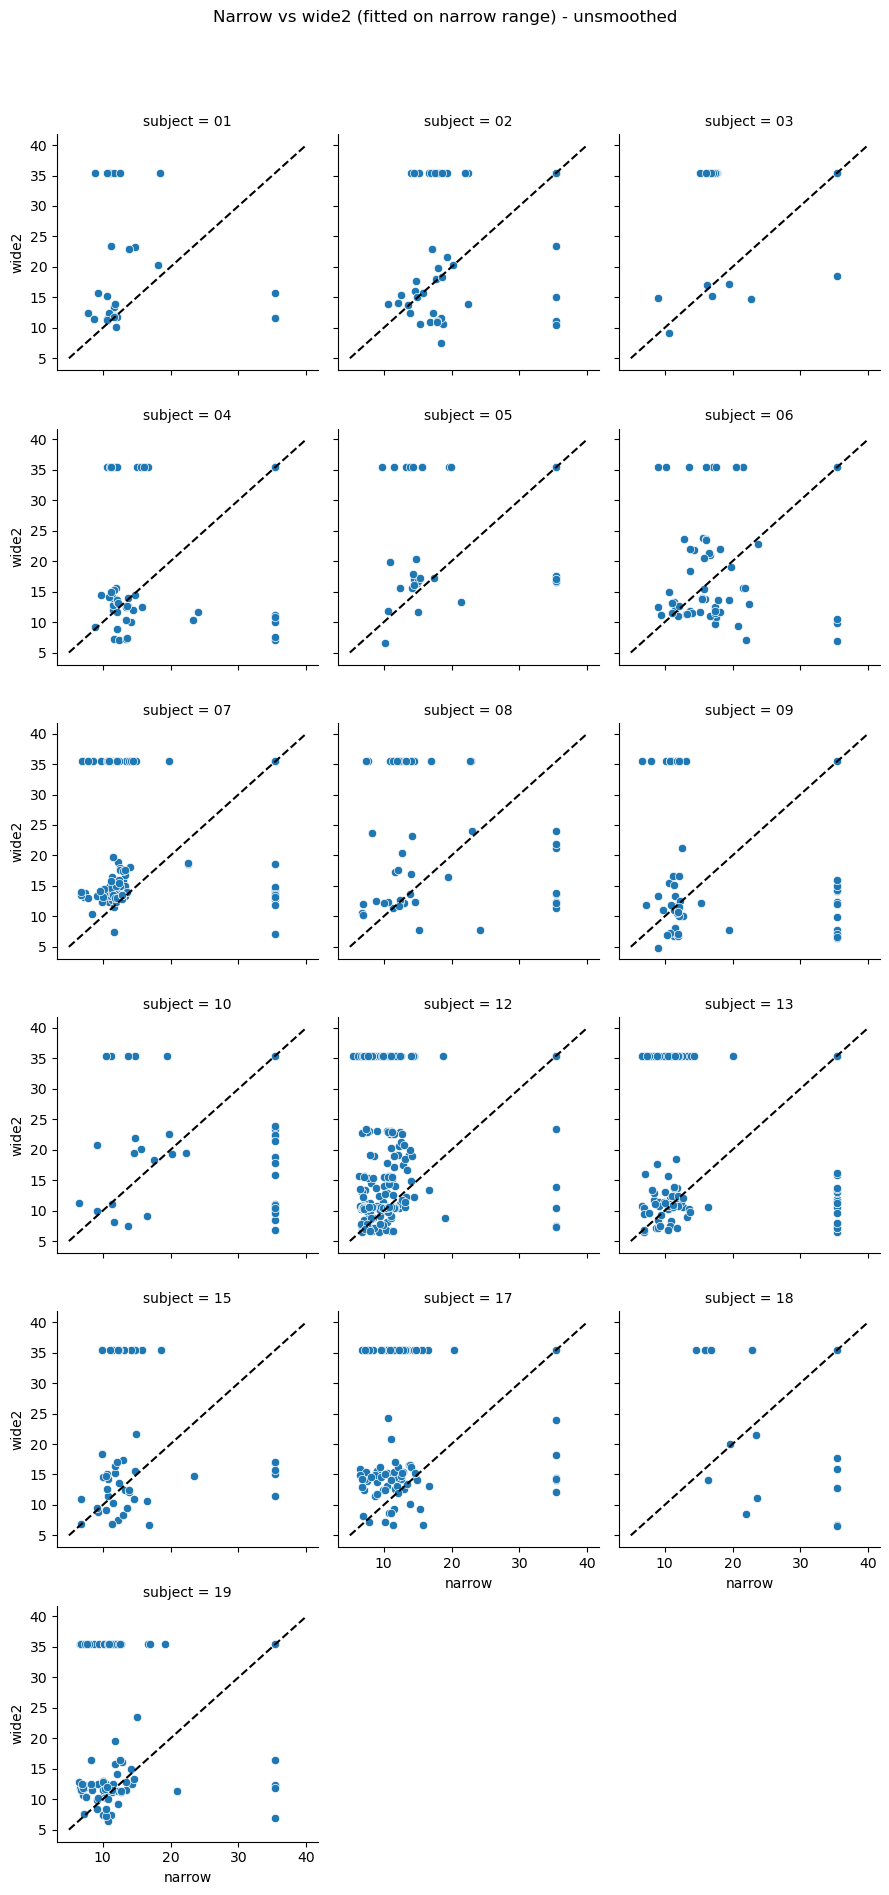

<Figure size 640x480 with 0 Axes>

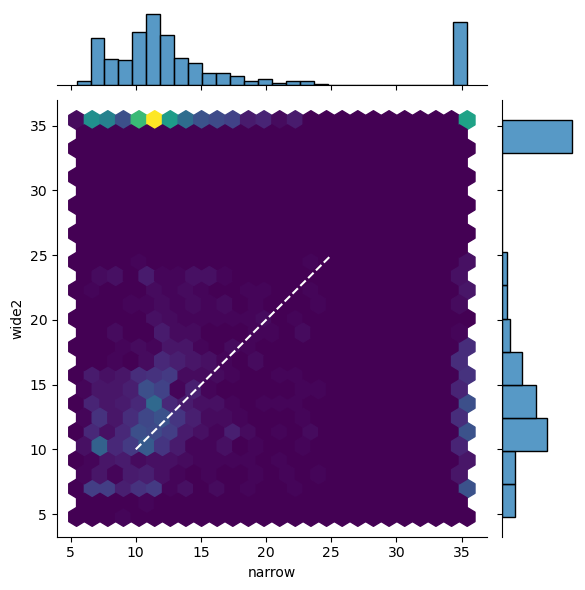

In [167]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide2')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide2 (fitted on narrow range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide2', kind='hex', cmap='viridis',
              gridsize=25)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

# Narrow vs wide (unfiltered)

In [84]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed']).sort_index()
tmp = tmp[(tmp[('cvr2', 'both')] > 0.00)]
# tmp = tmp[tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.00]
# tmp = tmp[(tmp[[('cvr2', 'wide2/'), ('cvr2', 'narrow')]] > 0.00).any(axis=1)]

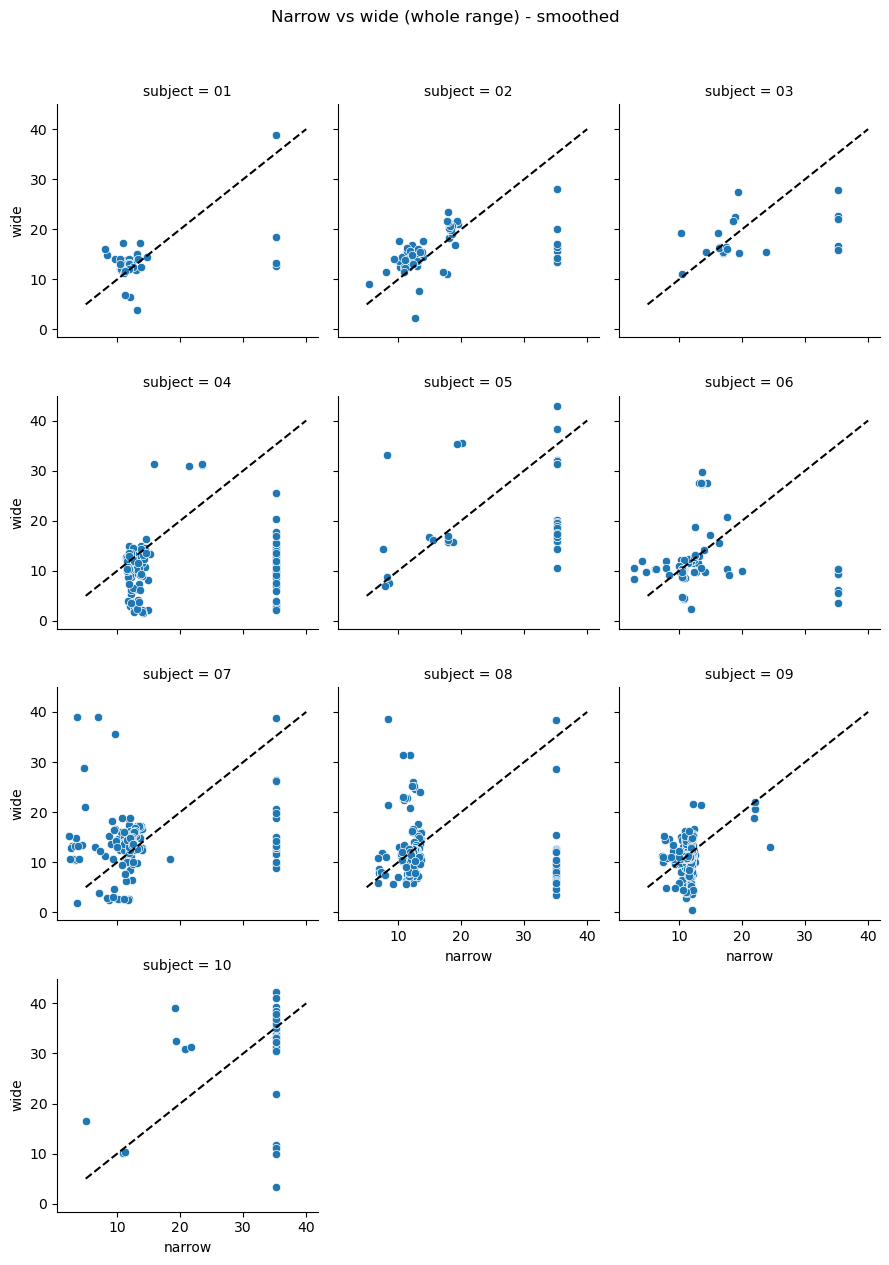

<Figure size 640x480 with 0 Axes>

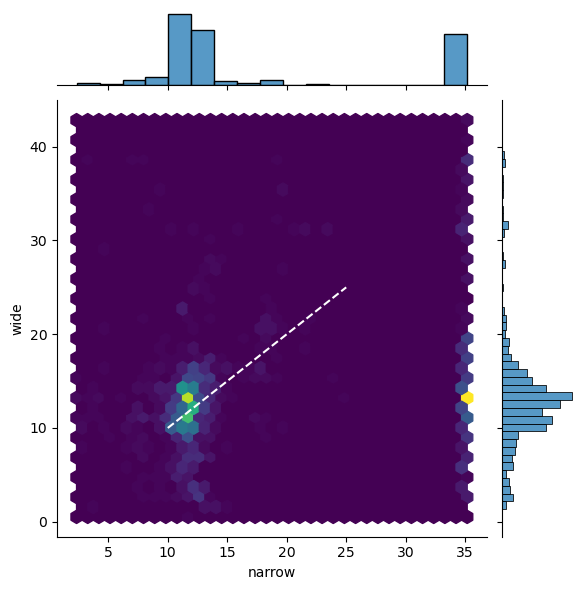

In [86]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

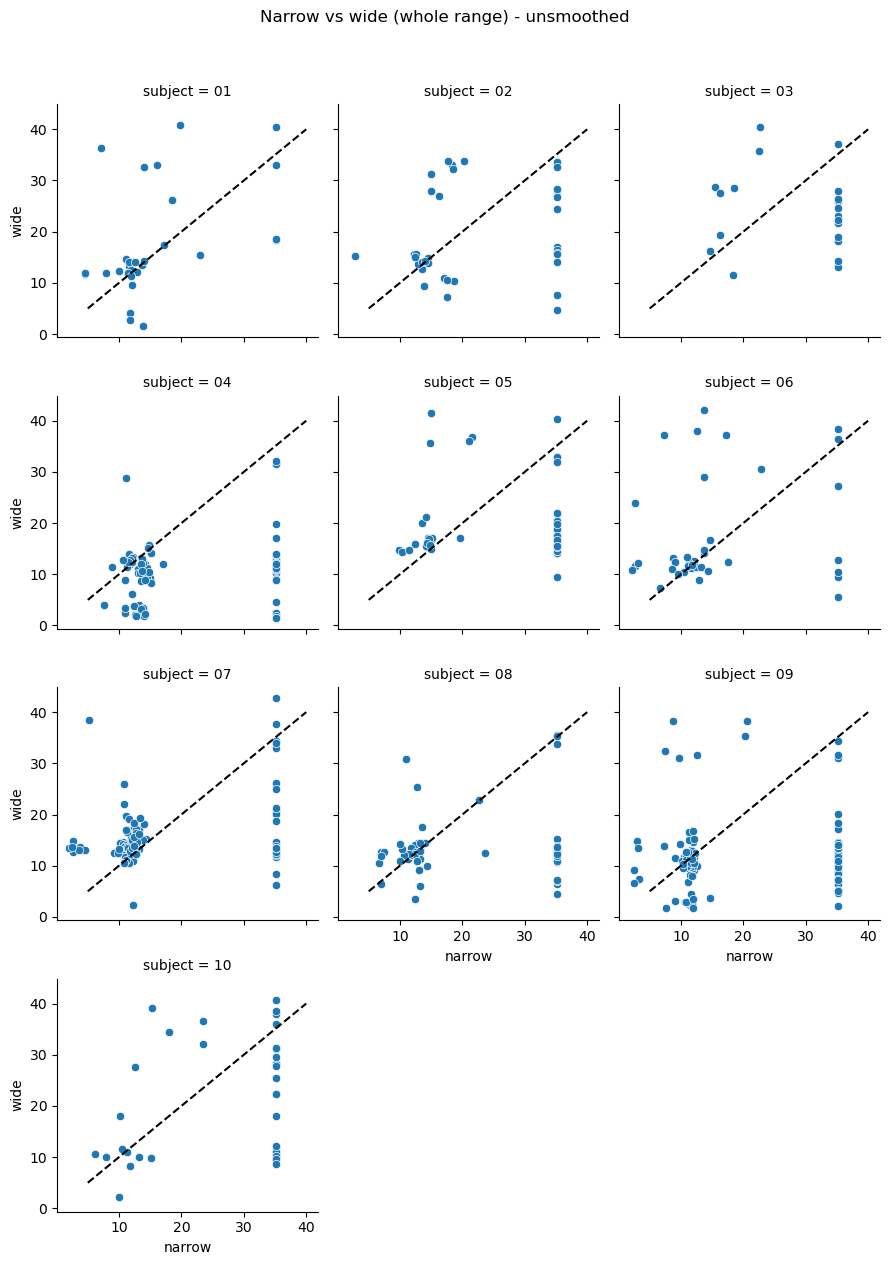

<Figure size 640x480 with 0 Axes>

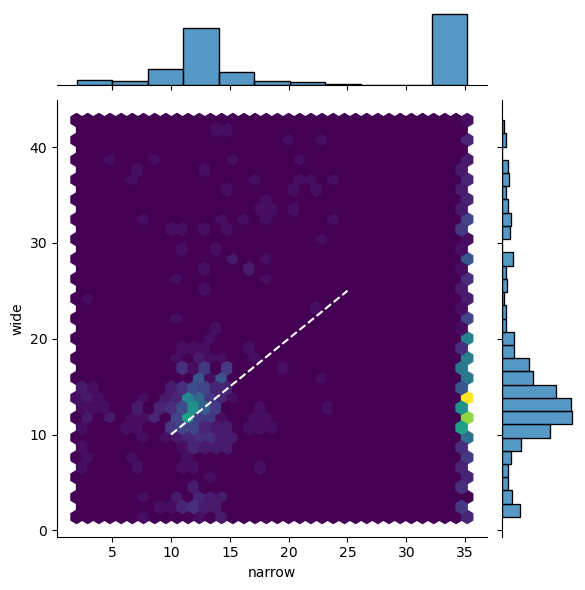

In [88]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/1278145697.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp[('mode', 'narrow')])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/1278145697.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp[('mode', 'w

<Axes: xlabel="('mode', 'wide')", ylabel='Density'>

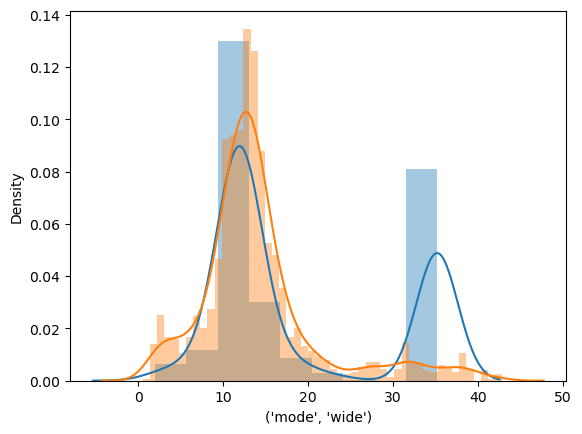

In [89]:
sns.distplot(tmp[('mode', 'narrow')])
sns.distplot(tmp[('mode', 'wide')])

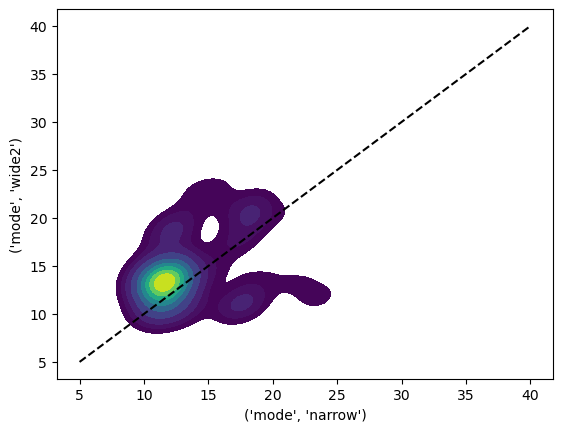

In [43]:
sns.kdeplot(data=tmp, x=('mode', 'narrow'), y=('mode', 'wide2'), fill=True, cmap='viridis')
plt.plot([5, 40], [5, 40], color='black', linestyle='--')

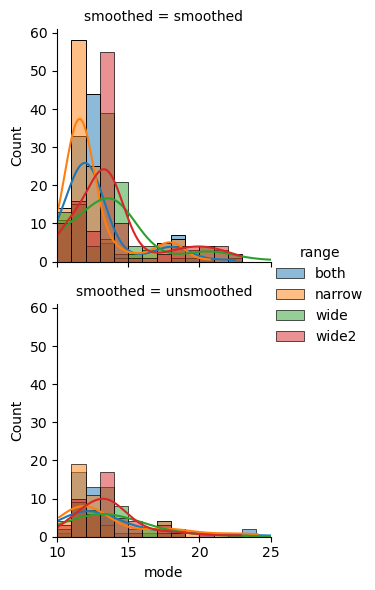

In [47]:
import seaborn as sns
import numpy as np

g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', row='smoothed')
g.map(sns.histplot, 'mode', kde=True, bins=np.arange(10, 25,1))
g.add_legend()
g.set(xlim=(10, 25))

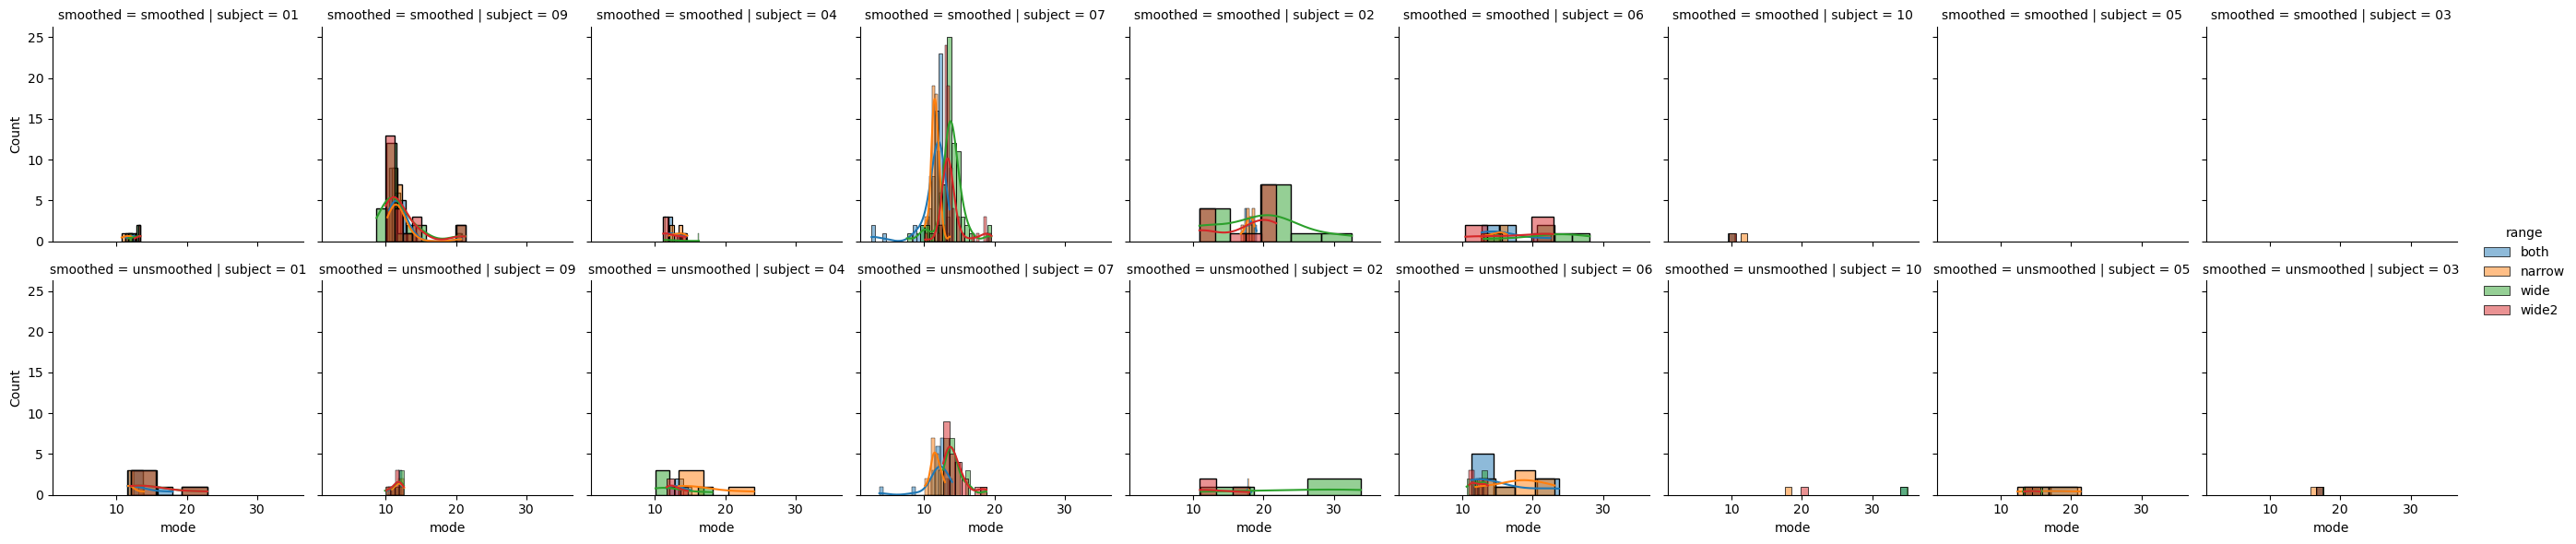

In [48]:
import seaborn as sns
g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', col='subject', row='smoothed')
g.map(sns.histplot, 'mode', kde=True)
g.add_legend()

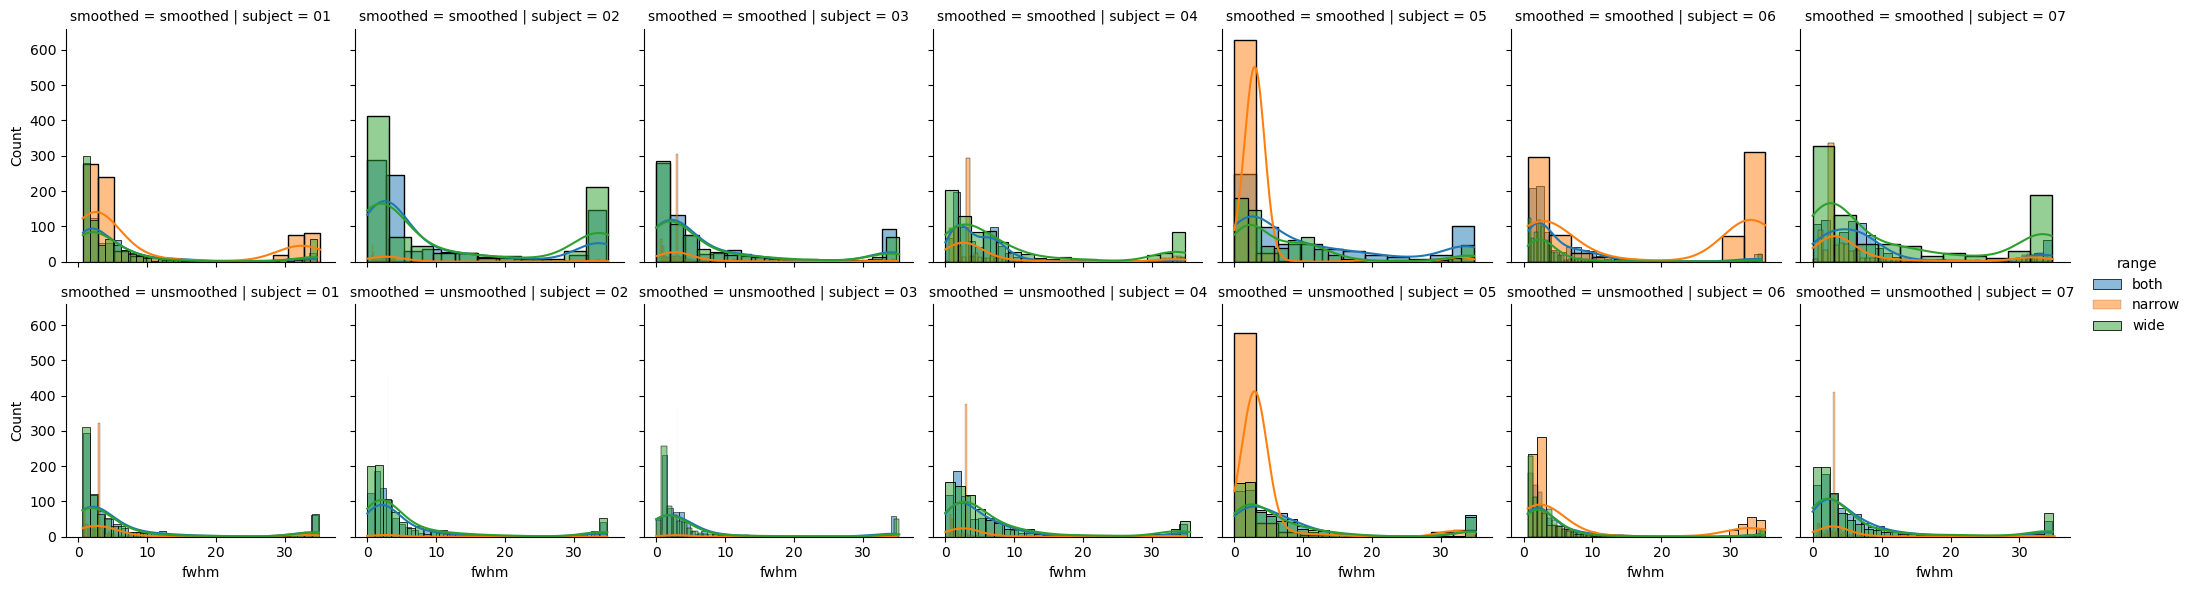

In [51]:
import seaborn as sns
g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', col='subject', row='smoothed')
g.map(sns.histplot, 'fwhm', kde=True)
g.add_legend()

In [90]:
sns.catplot(x='range', y='amplitude', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexes/multi.py", line 1542, in _get_level_number
    level = self.names.index(level)
ValueError: 'range' is not in list

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/2351929872.py", line 1, in <module>
    sns.catplot(x='range', y='amplitude', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/frame.py", line 9394, in stack
    result = stack(self, level, dropna=dropna, sort=sort)
  File "/Users/gdehol/mambaforge/lib/python3.

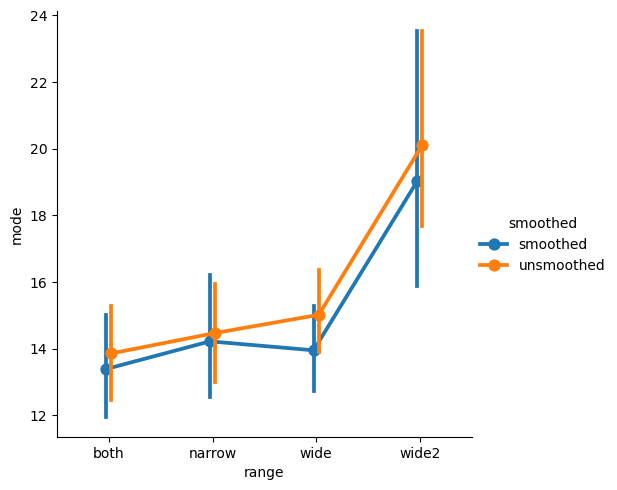

In [89]:
sns.catplot(x='range', y='mode', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)

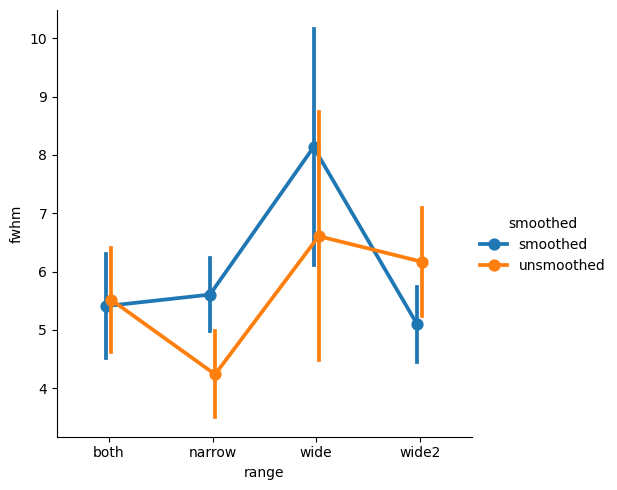

In [51]:
sns.catplot(x='range', y='fwhm', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True, errorbar='se')

(0.0, 40.0)

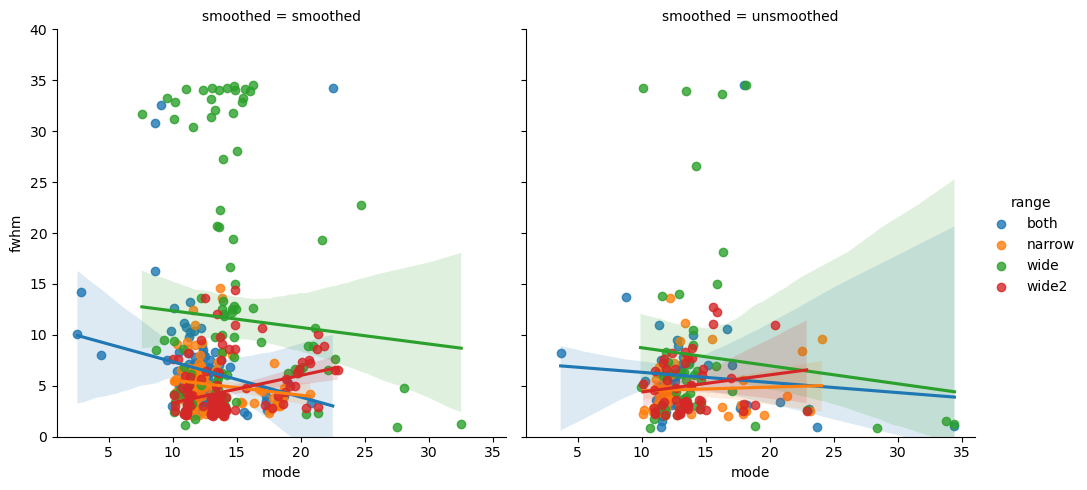

In [52]:
import matplotlib.pyplot as plt
sns.lmplot(x='mode', y='fwhm', data=tmp.stack('range').reset_index(), col='smoothed', hue='range')

plt.ylim(0, 40)

In [65]:
(tmp['mode'] < 25).all(1)

session  smoothed         subject
both     smoothed    0    01         False
                          02         False
                          03         False
                          04         False
                          05         False
                                     ...  
         unsmoothed  887  07         False
                     888  07          True
                     889  07          True
                     890  07         False
                     891  07          True
Length: 10988, dtype: bool

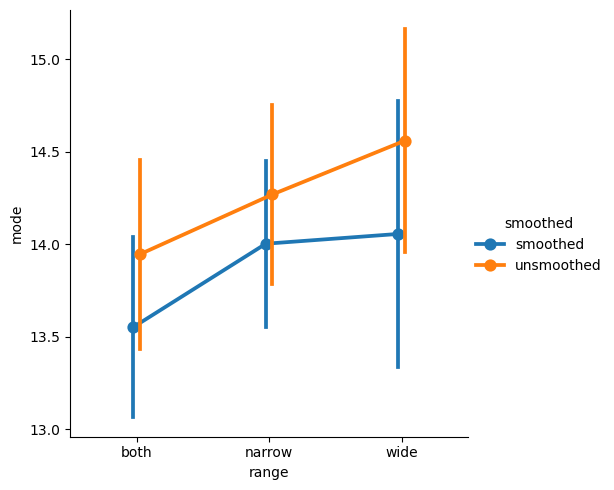

In [70]:
tmp = df.stack(['subject'])
tmp = tmp.loc[(tmp['mode'] < 25).all(1)]

sns.catplot(x='range', y='mode', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True,
            errorbar='se')

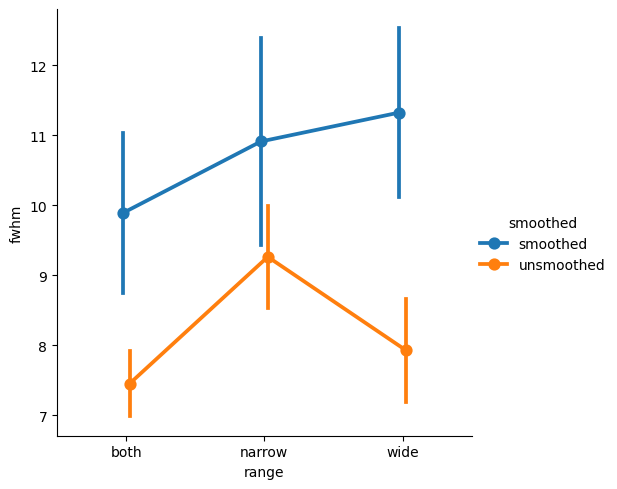

In [73]:
tmp = df.stack(['subject'])
tmp = tmp.loc[(tmp['mode'] < 25).all(1)]

sns.catplot(x='range', y='fwhm', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True,
            errorbar='se')

In [33]:
df['cvr2'].stack('subject').groupby(['subject']).apply(lambda d: d.corr())

range               wide    narrow      both
subject range                               
01      wide    1.000000  0.156808  0.590570
        narrow  0.156808  1.000000  0.391646
        both    0.590570  0.391646  1.000000
02      wide    1.000000  0.041252  0.459547
        narrow  0.041252  1.000000  0.294789
        both    0.459547  0.294789  1.000000
03      wide    1.000000  0.038834  0.355911
        narrow  0.038834  1.000000  0.242084
        both    0.355911  0.242084  1.000000
04      wide    1.000000  0.098691  0.632103
        narrow  0.098691  1.000000  0.296806
        both    0.632103  0.296806  1.000000
05      wide    1.000000  0.258374  0.702957
        narrow  0.258374  1.000000  0.420658
        both    0.702957  0.420658  1.000000
06      wide    1.000000  0.184195  0.562276
        narrow  0.184195  1.000000  0.385993
        both    0.562276  0.385993  1.000000
07      wide    1.000000  0.433093  0.695244
        narrow  0.433093  1.000000  0.643052
        both    0.695244  0.643052  1.000000

In [97]:
df['mode'].stack('subject').groupby(['subject', 'smoothed']).apply(lambda d: d.corr())

range                          wide    narrow      both
subject smoothed   range                               
01      smoothed   wide    1.000000  0.255567  0.576580
                   narrow  0.255567  1.000000  0.344114
                   both    0.576580  0.344114  1.000000
        unsmoothed wide    1.000000  0.134460  0.517123
                   narrow  0.134460  1.000000  0.265426
                   both    0.517123  0.265426  1.000000
02      smoothed   wide    1.000000  0.123189  0.529042
                   narrow  0.123189  1.000000  0.305775
                   both    0.529042  0.305775  1.000000
        unsmoothed wide    1.000000  0.039004  0.496808
                   narrow  0.039004  1.000000  0.172157
                   both    0.496808  0.172157  1.000000
03      smoothed   wide    1.000000  0.150447  0.575289
                   narrow  0.150447  1.000000  0.301796
                   both    0.575289  0.301796  1.000000
        unsmoothed wide    1.000000  0.231435  0.564900
                   narrow  0.231435  1.000000  0.429132
                   both    0.564900  0.429132  1.000000
04      smoothed   wide    1.000000  0.117579  0.586492
                   narrow  0.117579  1.000000  0.213618
                   both    0.586492  0.213618  1.000000
        unsmoothed wide    1.000000  0.120565  0.653789
                   narrow  0.120565  1.000000  0.242744
                   both    0.653789  0.242744  1.000000
05      smoothed   wide    1.000000  0.041145  0.482508
                   narrow  0.041145  1.000000  0.194150
                   both    0.482508  0.194150  1.000000
        unsmoothed wide    1.000000  0.009011  0.580497
                   narrow  0.009011  1.000000  0.109335
                   both    0.580497  0.109335  1.000000
06      smoothed   wide    1.000000  0.060599  0.582315
                   narrow  0.060599  1.000000  0.320384
                   both    0.582315  0.320384  1.000000
        unsmoothed wide    1.000000  0.073477  0.553875
                   narrow  0.073477  1.000000  0.218845
                   both    0.553875  0.218845  1.000000
07      smoothed   wide    1.000000  0.200234  0.448641
                   narrow  0.200234  1.000000  0.250176
                   both    0.448641  0.250176  1.000000
        unsmoothed wide    1.000000  0.118196  0.566392
                   narrow  0.118196  1.000000  0.273493
                   both    0.566392  0.273493  1.000000